# Part 1: Core concepts and intuitions behind dimensionality reduction 




### Foreword

- There are primarily two "families" of dimensionality reduction algorithms: matrix factorization methods and neighborhood graph methods. 

- Autoencoders are an exception, and they deserve their own category, but this is a caveat.

- I'll be focusing more on `matrix factorization` methods (sometimes called `factor-based` methods), as they are likely more relevant to the problems you'll encounter with typical tabular data. 



- `Neighborhood graph` methods, on the other hand, are based on the idea of maintaining the neighborhood relationships of data points during the dimensionality reduction. They differ fundamentally from matrix factorization techniques in their approach and objectives.








<center><img src="dim_reduction.png" alt="Drawing" style="width: 1200px;"/></center>


- Methods like [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html), and [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html), which fall under `neighborhood graph` methods (also known as `projection-based` methods), are particularly well-suited for ***homogeneous*** data that follows a ***specific topology***. Think pixels in an image or words in a sentence.

- Such methods tend to shine when working with image or natural language datasets, especially when lower-dimensional visualizations are required.  

- However, tabular datasets often comprise features of varied types, scales, and distributions. `Neighborhood graph` methods may not always be ideal for these datasets. Hence, our emphasis will be on matrix factorization methods which are often better suited for diverse tabular data.

**For the interested, [this](https://stanford.edu/~rezab/papers/glrm.pdf) is an excellent paper on both families of algorithms. Its long, but i promise its an easy read.**

## Please **run this first** to make sure all necessary files are downloaded

In [40]:


import requests

def download_file(url, local_filename):
    response = requests.get(url)
    with open(local_filename, 'wb') as f:
        f.write(response.content)

root = 'https://raw.githubusercontent.com/NiloyPurkait/Unsupervised-learning/master'
dim_root = f'{root}/Dimensionality-Reduction'

files_to_download = [
    (f'{dim_root}/dim_reduction_helpers.py', 'dim_reduction_helpers.py'),
    (f'{root}/Clustering/clustering_intro_helpers.py', 'clustering_intro_helpers.py'),
    (f'{dim_root}/mat_fac.png', 'mat_fac.png'),
    (f'{dim_root}/mat_fac_row.png', 'mat_fac_row.png'),
    (f'{dim_root}/dim_reduction.png', 'dim_reduction.png')
]

for url, filename in files_to_download:
    download_file(url, filename)


In [41]:
# Surpress any warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


import numpy as np
import matplotlib.pyplot as plt
from dim_reduction_helpers import *
from clustering_intro_helpers import *

from sklearn.model_selection import train_test_split

random_state = 42
np.random.seed(random_state)

#### Generate some data for classification

In [42]:


# Number of points
n_points = 400

# Generate x1 values randomly within a domain
a = np.sort(2 * np.pi * np.random.rand(n_points))

# Generate x2 values using the sine function
b = np.sin(a)

# Add random noise to y values to scatter points around the sine curve
noise_strength = 0.2
b += noise_strength * np.random.randn(n_points)

x_1 = np.expand_dims(a, axis=-1)
x_2 = np.expand_dims(b, axis=-1)
X = np.concatenate([x_1,x_2], axis=1)

y = np.where((b > 1) | (b < -1) | (b>0.5) | (b<-.5), 1,0)


#### Split into training and test sets



In [43]:
X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y, random_state=0)

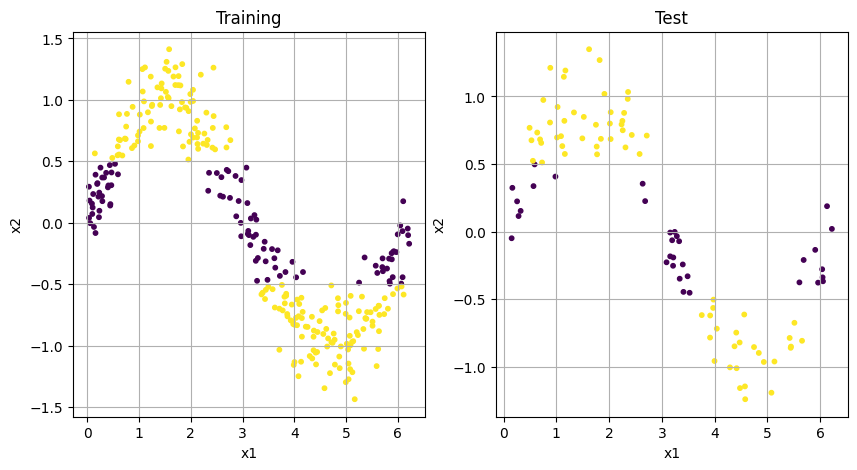

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

# Plot the randomly distributed S shape
#plt.figure(figsize=(6, 4))
ax[0].scatter(X_train[:,0], X_train[:,1], s=10, c=y_train, cmap='viridis')
ax[0].set_title('Training')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].grid(True)


ax[1].scatter(X_test[:,0], X_test[:,1], s=10, c=y_test, cmap='viridis')
ax[1].set_title('Test')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[1].grid(True)


plt.show()


#### Find Principal Components
PCA identifies directions maximizing variance, not necessarily distinguishing classes.

- `n_components` is a parameter you can set to tell the algorithm how many archetypes to break the data into (more on this later)
- `.fit()` will fit the PCA to some data
- `.transform()` method can be called on a fitted `PCA` object to transform some data according to the previously fitted components


In [45]:
from sklearn.decomposition import PCA

# initialize
pca = PCA(n_components=2)

# fit on data
pca.fit(X_train)

# transform other data
score_pca =  pca.transform(X_test)


<details>


<summary> <b> Why use PCA on 2D data? :</b> </summary>

1. **Realign Data**: If data spreads in a specific diagonal or non-axis-aligned direction, PCA can align it with this main direction.
 
2. **Highlight Variance**: PCA can show if most data variability is in one specific direction.

3. **Noise Reduction**: By discarding the component with less variance, one can reduce noise.

4. **Preprocessing**: PCA mean-centers data and removes correlations, useful for some subsequent analyses.

5. **Emphasize Variability in Visualization**: PCA plots highlight primary patterns in the dataset.

</details>



- If we plot the transformed projection onto both principal components, we see the data looks the same, or `isotropic`, meaning that it has the same value when measured in a different coordinate system. 
- This is because the data is `symmetric` and the variance is equal on each side. As a result, PCA will not help us classify the data.


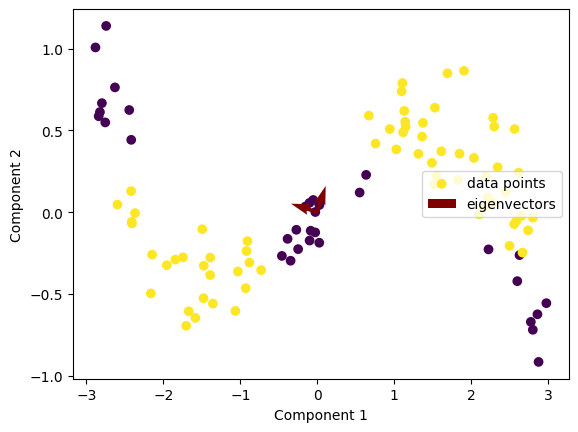

In [46]:
plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test,label="data points", cmap='viridis')

plt.quiver([0,0],[0,0], pca.components_[0,:], pca.components_[1,:], label="eigenvectors", color='maroon')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='center right')
plt.show()



#### This function `plot_proj` visualizes data points from a dataset as well as their projections onto a component

- plots a PCA line based on the provided PCA components `c`
- draws lines from each data point to its projection on the PCA line.


```python

def plot_proj(data,c,target,name=None):
    # Plot the data points 'data' with colors based on their labels 'target'
    plt.scatter(data[:,0], data[:,1], label='data', c=target, cmap='viridis')

    # Plot the main PCA line using the provided PCA components 'c'
    plt.plot(np.linspace(-1,1), np.linspace(-1,1)*(c[1]/c[0]), color='black', linestyle='--', linewidth=1.5, label=name)
    
    # Loop over each data point in 'data' to plot the projection lines
    for i in range(len(data[:,0])-1):
        # Define the current data point 'w'
        w = data[i,:]

        # Calculate the projection of current data point on the PCA line
        cv = (np.dot(data[i,:], c)) / np.dot(c, np.transpose(c)) * c

        # Draw a line from the data point to its projection on the PCA line
        plt.plot([data[i,0], cv[0]], [data[i,1], cv[1]], 'r--', linewidth=1.5)

    # Draw the projection line for the last data point (to include in the legend)
    plt.plot([data[-1,0], cv[0]], [data[-1,1], cv[1]], 'r--', linewidth=1.5, label='projections')

    # Add a legend to the plot
    plt.legend()
    # Display the plot
    plt.show()
```


#### If projections for both classes move in the same direction on a principal component:

- No Class Separation: This component may not differentiate between classes, reducing its usefulness for classification tasks.

- Shared Variance: Both classes exhibit similar trends, suggesting a common underlying factor in the data.

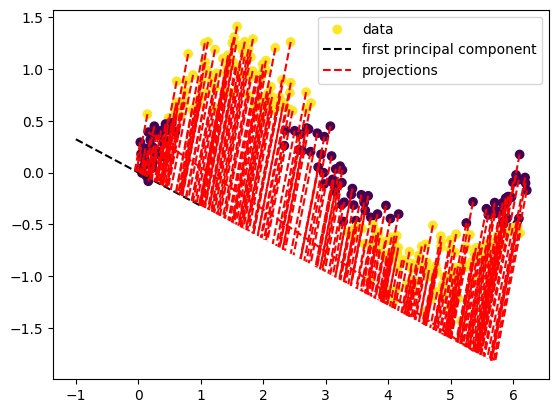

In [47]:
plot_proj(X_train,pca.components_[0,:],y_train,"first principal component")

#### We can also plot out the actual points of projection onto all the principal components
- This is the transformed data, also known as their scores for the principal component. 
- We again see that the dataset is not linearly separable, as data points from different classes cannot be separated with a line :


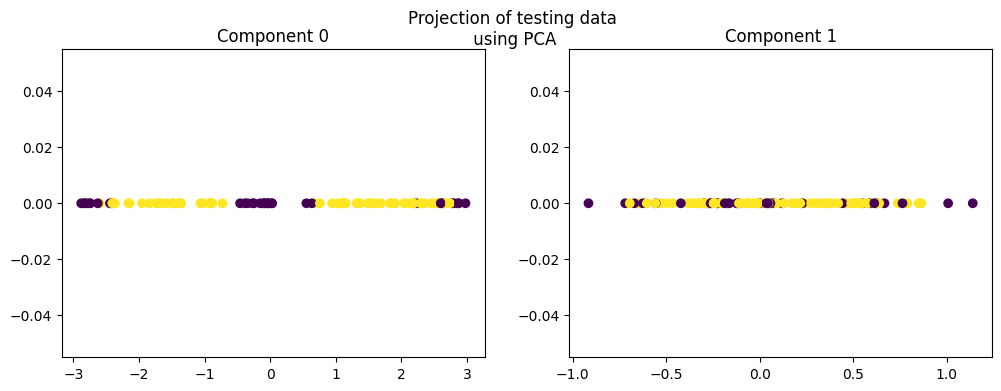

In [48]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

# loop over all components
for i in range(score_pca.shape[1]):
    ax[i].scatter(score_pca[:,i],np.zeros(score_pca[:,1].shape[0]),c=y_test,cmap='viridis')
    ax[i].set_title(f'Component {i}')


plt.suptitle("Projection of testing data\n using PCA")
plt.show()

#### Building a Logistic Regression model on the training set

- Since we established the data is not linearly seperable, a linear classifier should not be able to solve this problem

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
# train
lr= LogisticRegression().fit(X_train, y_train)


#predict
print(str.format("Test set  mean accuracy score for for PCA: {}", lr.score(X_test, y_test)))

Test set  mean accuracy score for for PCA: 0.67


The accuracy might look good, but how does a majority classifier perform? 

In [51]:

sum(y_test)/len(y_test)

0.67

The result is thus not so great. Hence, we can see that it'd be unsuitable to project the data onto a low-dimensional linear subspace.

### A solution : Polynomial transformations

A polynomial transform expands a dataset's features by adding polynomial combinations of the original features. 

**Why?**
1. **Capture Non-linearity**: It helps models represent non-linear relationships.
2. **Model Improvement**: Can enhance performance by fitting data better.
3. **Feature Interactions**: It introduces interaction terms, capturing combined effects of features.


In essence, polynomial transforms help models fit complex relationships but should be used with caution due to potential overfitting and computational challenges.


The transformation we are about to apply is simple:

$$
\mathbf{\phi}(\mathbf{x}) = \begin{bmatrix} a \\ b \\ b^2 \end{bmatrix}
$$
where 
$$
\mathbf{x} = \begin{bmatrix} a \\ b \end{bmatrix}
$$


- Transform the training and test data by adding an extra feature

In [52]:
# transform second feature
x2_train_poly = np.expand_dims(X_train[:,1]**2, -1)

# append as column to original data
X_train_transformed = np.concatenate([X_train, x2_train_poly], axis=-1)

# make into dataframe
polynomial_train = pd.DataFrame(X_train_transformed, columns=['x1', 'x2', 'x2_poly']).assign(target=y_train)

In [53]:
# Do the same for test set

x2_test_poly = np.expand_dims(X_test[:,1]**2, -1)

X_test_transformed = np.concatenate([X_test, x2_test_poly], axis=-1)

polynomial_test = pd.DataFrame(X_test_transformed, columns=['x1', 'x2', 'x2_poly']).assign(target=y_test)

In [54]:
plot_3d(polynomial_train, ['x1', 'x2', 'x2_poly', 'target'], title='Plotting all features')

- Now get Principal components of the transformed data

In [55]:
pca = PCA(n_components=3)
score_poly = pca.fit(polynomial_train).transform(polynomial_test)

- We see that on the second component, the data is linearly seperable now!

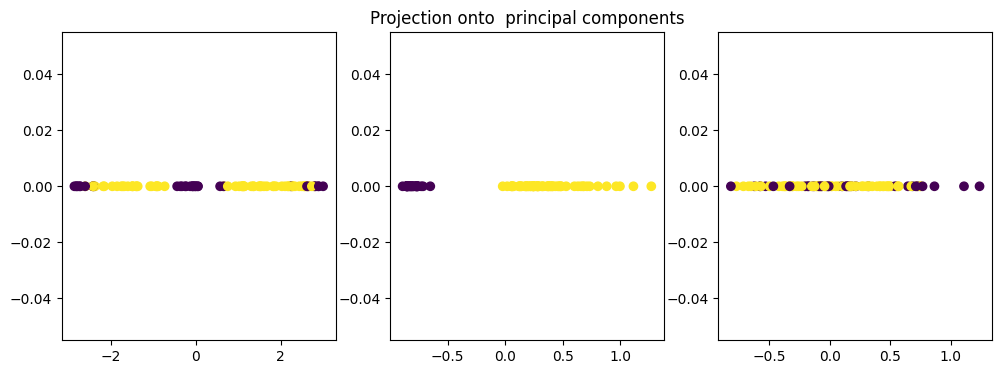

In [56]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

for i in range(score_poly.shape[1]):
    ax[i].scatter(score_poly[:,i],np.zeros(score_poly[:,1].shape[0]),c=y_test,cmap='viridis')
ax[1].set_title("Projection onto  principal components")
plt.show()

We can also see this by projecting onto a plane formed by the top two principal components (the ones with the largest absolute eigenvalues)

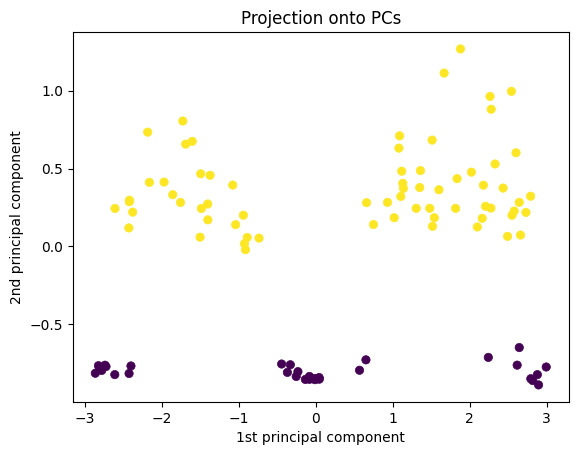

In [57]:
plt.scatter(score_poly[:,0], score_poly[:,1],c=y_test, cmap='viridis', linewidth=0.5)
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection onto PCs")
plt.show()

### Classifying with transformed dataset

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:

lr= LogisticRegression().fit(X_train_transformed, y_train)
print(str.format("Test set  mean accuracy score for for PCA: {}", lr.score(X_test_transformed, y_test)))

Test set  mean accuracy score for for PCA: 0.97


### Classifying with the top 2 components



In [60]:

lr= LogisticRegression().fit(X_train_transformed[:, 1:], y_train)
print(str.format("Test set  mean accuracy score for for PCA: {}", lr.score(X_test_transformed[:, 1:], y_test)))

Test set  mean accuracy score for for PCA: 0.97


### Classifying on the original feature space

In [61]:

lr= LogisticRegression().fit(X_train_transformed[:, :2], y_train)
print(str.format("Test set  mean accuracy score for for PCA: {}", lr.score(X_test_transformed[:, :2], y_test)))

Test set  mean accuracy score for for PCA: 0.67




## Kernel PCA

- From the previous example, we can see that mapping the data to a higher dimension first is helpful. 
- It turns out, we can use the [kernel trick](https://medium.com/@zxr.nju/what-is-the-kernel-trick-why-is-it-important-98a98db0961d) to perform `PCA` in this **transformed space** without calculating polynomial transformation explicitly. This saves time and compute power!



<details>
<summary>Want to get an idea of the math?</summary>

### For two samples $\mathbf{x}$ and  $ \mathbf{x'} $, we can calculate the second order polynomial kernel by setting $p=2$ and applying the following:

$k(\mathbf{x}, \mathbf{x'}) = \phi(\mathbf{x})^\mathsf{T}\phi(\mathbf{x'}) = (\mathbf{x}^\mathsf{T} \mathbf{x'} + c)^{p} $, where $c$ is a constant usually one

This is of complexity $\mathcal{O}(D)$ coming from $\mathbf{x}^\mathsf{T} \mathbf{x}$; we can also increase the order of the polynomial by changing $p$ and that wouldn't change the computation complexity.


In this notebook we used the [Radial Basis Function (RBF) kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01>)- the  dimension $\phi(\mathbf{x})$ is infinite, but the kernel is simple to calculate as shown here:
                                                                  
$ k(\mathbf {x} ,\mathbf {x'} )=\exp \left(-{\frac {|\mathbf {x} -\mathbf {x'} |^{2}}{2\sigma ^{2}}}\right) $


Kernel calculation involves evaluating the Gram matrix, shown from $N$ samples, as well as its eigenvector and eigenvalues. Hence, if there are a lot of samples in your training set, you may encounter issues.

$ K= \begin{vmatrix}
k(\mathbf{x}\_1, \mathbf{x}\_1) & k(\mathbf{x}\_1, \mathbf{x}\_2)&\dots &  k(\mathbf{x}\_1, \mathbf{x}\_N) \\\\
k(\mathbf{x}\_2, \mathbf{x}\_1)  & k(\mathbf{x}\_2, \mathbf{x}\_2)  &\dots & k(\mathbf{x}\_2, \mathbf{x}\_N) \\\\
\vdots & \vdots & \ddots & \vdots \\\\
k(\mathbf{x}\_N, \mathbf{x}\_1)  & k(\mathbf{x}\_N, \mathbf{x}\_2)  &\dots & k(\mathbf{x}\_N, \mathbf{x}\_N) \\\\
\end{vmatrix}$
</details>

In [62]:
from sklearn.decomposition import KernelPCA

In [63]:
kernel_pca = KernelPCA( kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1)

`n_components`: Number of components. If None (the default), all non-zero components are kept.

`kernel`: Kernel used for PCA Kernels is one of the following: {`linear`, `poly`, `rbf`, `sigmoid`, `cosine`, `precomputed`}. Default is `linear`.

`gamma`: $\gamma$ is the Kernel coefficient for RBF, poly, and sigmoid kernels, but ignored by other kernels. If `gamma` is `None` (the default), then it is set to `1/n_features`.

`alpha`: Hyperparameter of the ridge regression that learns the inverse transform (when fit_inverse_transform=True).

### Some of the available polynomial transforms

#### (and what it does to different data)


<center> <img src="https://www.researchgate.net/profile/Kenneth-Ezukwoke/publication/337933124/figure/fig3/AS:836041653121025@1576339271517/PCA-and-Kernel-PCA-with-g-1-d-5.ppm" alt="Drawing" style="width: 1000px;"/>

- Fit the Kernel PCA object on training data

In [64]:
kernel_pca.fit(X_train)

KernelPCA(alpha=0.1, fit_inverse_transform=True, gamma=10, kernel='rbf')

- Transform both train and test data

In [65]:
score_kernel_pca_train = kernel_pca.transform(X_train)
score_kernel_pca_test = kernel_pca.transform(X_test)

In [66]:
X_train.shape

(300, 2)

In [67]:
#bit of an overkill
score_kernel_pca_train.shape

(300, 299)

<details>
<summary> <b>Why 299 dimensions?</b></summary><br>

**Kernel PCA** with the `RBF kernel` produces a kernel matrix based on your dataset's samples. For a dataset of 300 samples, this results in a 300x300 matrix. 
-The maximum number of non-zero eigenvalues (and thus dimensions) you get from this matrix is \( n-1 \), or 299 for your dataset.
- While the RBF kernel implies infinite dimensions, in practice, you're limited by the number of samples. 
- Typically, not all of these 299 dimensions are significant; only a subset that captures most of the variance is typically used.

This doesn't mean you're "increasing" the dimensionality; rather, you're representing the data in a high-dimensional, non-linear feature space where the original relationships between data points are encoded in the form of their `pairwise similarities`.

</details>

In [68]:
# but can now solve the problem

lr= LogisticRegression().fit(score_kernel_pca_train, y_train)
print(str.format("Test set  mean accuracy score for for PCA: {}", lr.score(score_kernel_pca_test, y_test)))

Test set  mean accuracy score for for PCA: 0.97


With Kernel PCA, exact explained variance isn't accessible, but by using `eigenvalue magnitudes`, we can gauge the variance explained by principal components. 

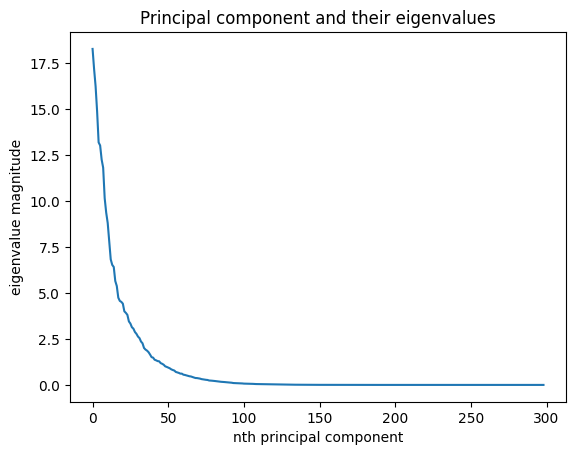

In [69]:
plt.plot(kernel_pca.eigenvalues_)

plt.title("Principal component and their eigenvalues")
plt.xlabel("nth principal component")
plt.ylabel("eigenvalue magnitude")
plt.show()

- The fitted `PCA` object has a `.inverse_transform()` method
- This lets you reconstruct the data using the transformed features and the principal components calculated
- In standard `PCA`, the reconstruction was exactly the same as the original component, if `n_components` is equal to the dimension of the original features. 

In [70]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_hat_pca = pca.inverse_transform(pca.transform(X_test))

- `Kernel PCA` does not actually span $\phi(\mathbf{x})$ but instead spans a subspace. Therefore, the inverse transformation will not always reconstruct the data, like in PCA. 


In [71]:
X_hat_kpca = kernel_pca.inverse_transform(kernel_pca.transform(X_test))

- We can verify this by comparing the inverse transformation of Kernel PCA and PCA.

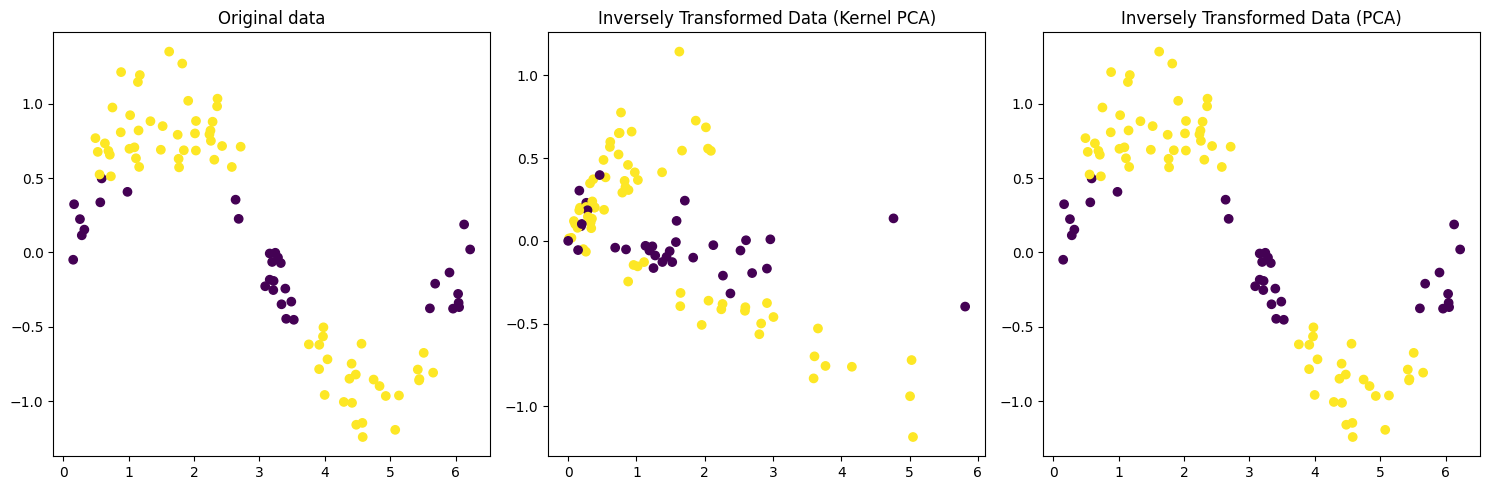

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original data plot
axes[0].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='viridis')
axes[0].set_title("Original data")

# Inversely Transformed Data (Kernel PCA) plot
axes[1].scatter(X_hat_kpca[:,0], X_hat_kpca[:,1], c=y_test, cmap='viridis')
axes[1].set_title("Inversely Transformed Data (Kernel PCA)")

# Inversely Transformed Data (PCA) plot
axes[2].scatter(X_hat_pca[:,0], X_hat_pca[:,1], c=y_test, cmap='viridis')
axes[2].set_title("Inversely Transformed Data (PCA)")

plt.tight_layout()
plt.show()


- Classic PCA employs a linear projection for dimensionality reduction, enabling straightforward reconstruction. 
- We can verify this by checking the reconstruction loss, or `mean squared error` between the original and reconstructed data

In [73]:
 #tansformed data is identical to original data
print("MSEr PCA is:" ,((X_test-X_hat_pca)**2).mean())

MSEr PCA is: 2.302676899452898e-31



- Classic PCA has a direct inverse, with its MSE stemming mainly from discarded variance.
- Conversely, Kernel PCA uses a nonlinear kernel mapping, complicating its feature space.
- Kernel PCA, lacking a direct inverse, uses approximation for reconstruction, adding more errors.
- Hence, the higher MSE in Kernel PCA's reconstruction arises from both discarded variance and approximation errors, while classic PCA's is mostly from the former.

In [74]:
print("MSE for Kernel PCA is:",((X_test-X_hat_kpca)**2).mean())

MSE for Kernel PCA is: 1.9722024973158878


## Matrix factorization methods : What is really going on?



- The idea is that we want to express our data as approximately equal to a product of two smaller matrices 
- This means that we are factorizing our data into (i.e. making our data divisible into) two matrices
- The transformed, **lower dimensional output** is refered to as the `representation` matrix
- The **components** themselves are refered to as `archetypes`, or the basic forms/exemplars used to reconstruct the original data


<img src="mat_fac.png" alt="Drawing" style="width: 1200px;"/></center>
<br>





#### **Given that $N$ is the number of observations, $D$ is the number of features per observation, our data $X$ is a $N$ x $D$ matrix**


#### **Now,  we want to find 2 matrices, $R$ and $A$, so that:**

####  $X \approx RA$ 

***where***



- $R$ is a $N$ x $d$ matrix
- $A$ is a $d$ x $D$ matrix
<br>

- So that each row of our dataset can now be expressed as a `representation` multiplied by some `archetypes`, or a ***linear combination*** of archetypes multiplied by some coefficients


<img src="mat_fac_row.png" alt="Drawing" style="width: 1200px;"/></center>




### **Problem** : How do we define **$\approx$**?


### **Solution**: Turn it into an optimization problem. The objective is simple:

-  #### **Minimise** : $\sum_{i=1}^{N} \sum_{j=1}^{D} \text{Loss}(x_{ij}, (RA)_{ij})$, 
- **subject to some constraints**, (we will come back to the constraints shortly)




#### As we saw, that $Loss$ function is `mean squared error`, which means classical `PCA` is essentially doing this:


- #### $\sum_{i=1}^{N} \sum_{j=1}^{D} (x_{ij} - (RA)_{ij})^2$

- Without any constraints



<details>

<summary> <b> Summary of Part 1 </b></summary>

**Kernel PCA Advantages**:
- Kernel PCA uses kernels to compute dot products in a higher-dimensional space without explicit transformations.
- Kernels, such as RBF or polynomial, can map non-linearly separable data into spaces where they become linearly separable.
- For certain datasets, RBF kernels can effectively separate data classes in the transformed space.
- This transformed space allows linear classifiers to perform effectively.

**Takeaway**:
Kernel PCA is invaluable when working with non-linear datasets. It emphasizes the need to understand data structures and select appropriate dimensionality reduction and classification techniques.

</details>


<details>
<summary> <b>Choosing number of components for Kernel PCA</b></summary>

Choosing the appropriate number of components (\( n\_components \)) for Kernel PCA (KPCA) can be a bit tricky since, unlike standard PCA, KPCA does not provide a direct measure of explained variance for each component. However, you can employ several strategies to help determine an optimal number of components:

1. **Explained Variance in Standard PCA**:
   Even though this method doesn't directly tell you the appropriate number of components for KPCA, you can start by performing standard PCA on your data. By plotting the explained variance (or the cumulative explained variance) against the number of components, you can get a rough idea of how many components might capture a significant amount of the data's structure.

2. **Visualization**:
   After applying KPCA, you can visualize the first few components (e.g., first vs. second, second vs. third) to see if they reveal any interesting structure or separation among the data points.

3. **Performance in Downstream Tasks**:
   If you are using KPCA as a preprocessing step for a subsequent task (e.g., classification, clustering), you can evaluate the performance of the task for different values of \( n\_components \). Choose the number of components that yields the best performance without overcomplicating the model. For example, you could use cross-validation to evaluate a classifier's accuracy using different numbers of KPCA components.

4. **Elbow Method**:
   Similar to standard PCA, after transforming the data with KPCA, you can compute the reconstruction error for different numbers of components. Plot the reconstruction error against the number of components, and look for an "elbow" point where adding more components doesn't significantly decrease the error. This method, however, can be computationally intensive as it involves reconstructing the data in the original space.

5. **Cumulative Kernel Eigenvalues**:
   In KPCA, eigenvalues resulting from the kernel matrix can give some indication of the importance of components. While these eigenvalues don't directly represent explained variance like in linear PCA, a plot of cumulative eigenvalues can still give you an intuition. You'd look for the point where the cumulative value starts leveling off.



Finally, remember that the choice of kernel and its parameters (e.g., the gamma value for the RBF kernel) will significantly impact the results. It's often beneficial to experiment with different kernels and their parameters alongside the number of components to get the best representation for your specific dataset and task.

<details>

# Part 2 : Interpretable versions of PCA


#### The data comes from the Wish platform, and is available on [Kaggle](https://www.kaggle.com/datasets/jmmvutu/summer-products-and-sales-in-ecommerce-wish/data) 
- It contains product listings as well as products ratings and sales performance

<center> <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1488294%2F308810459ae5232399672ba3eef228ef%2Fannotated-search-results-wish-website.jpg?generation=1598785563117062&alt=media" alt="Drawing" style="width: 1000px;"/>

In [75]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold





- Each row represents a product
- I have preprocessed the data to get the 'boring' parts out of the way, but you can look at the steps i take by refering to the `preprocess_wish_dataset()` helper function, in the supporting script

In [78]:
df_clean = preprocess_wish_dataset(dim_root)

df_scale=df_clean.copy(deep=True)

df_clean.head()

The number of categorical variables: 4; where 1 ordinal variable and 35 dummy variables
The number of numeric variables: 23


,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,...,shipping_option_name_الشحن القياسي,shipping_option_name_การส่งสินค้ามาตรฐาน,shipping_option_name_ការដឹកជញ្ជូនតាមស្តង់ដារ,origin_country_AT,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_Unknown,origin_country_VE
0,16.00,14,100,0,3.76,54,26.0,8.0,10.0,1.0,...,0,0,0,0,1,0,0,0,0,0
1,8.00,22,20000,1,3.45,6135,2269.0,1027.0,1118.0,644.0,...,0,0,0,0,1,0,0,0,0,0
2,8.00,43,100,0,3.57,14,5.0,4.0,2.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,8.00,8,5000,1,4.03,579,295.0,119.0,87.0,42.0,...,0,0,0,0,1,0,0,0,0,0
4,2.72,3,100,1,3.10,20,6.0,4.0,2.0,2.0,...,0,0,0,0,1,0,0,0,0,0


#### Filter binary variables, scale continuous only

If you want to use the `VarianceThreshold` technique to find non-binary columns, setting the threshold to \(0.25\) is a useful approach. Here's the logic:

In the case of binary columns (with values 0 and 1):

- If the column is perfectly balanced (50% zeros and 50% ones), its variance will be \(0.25\).
- If it's skewed (e.g., more than 75% ones or zeros), its variance will be less than \(0.25\).

By setting the threshold to \(0.25\), any column with a variance strictly greater than \(0.25\) will be retained, which means it's a non-binary column. <br>
Columns with variance less than or equal to \(0.25\) will likely be binary columns (or columns with very low variance) and will be excluded.

In [79]:
# Apply variance threshold
selector = VarianceThreshold(threshold=0.25)
selector.fit(df_clean)

# Get the non-binary columns
non_binary_cols = df_clean.columns[selector.variances_ > 0.25]

#print(non_binary_cols)

#### Scale the data

In [80]:
scaler = MinMaxScaler()

scaled_cols = pd.DataFrame(scaler.fit_transform(df_clean[non_binary_cols]), columns=non_binary_cols)

df_scale = df_scale.assign(**scaled_cols)

In [81]:
df_scale.head()

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,...,shipping_option_name_الشحن القياسي,shipping_option_name_การส่งสินค้ามาตรฐาน,shipping_option_name_ការដឹកជញ្ជូនតាមស្តង់ដារ,origin_country_AT,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_Unknown,origin_country_VE
0,0.312500,0.051793,0.000990,0,0.6900,0.002603,0.002251,0.001927,0.002734,0.000499,...,0,0,0,0,1,0,0,0,0,0
1,0.145833,0.083665,0.199992,1,0.6125,0.295748,0.196484,0.247351,0.305631,0.321518,...,0,0,0,0,1,0,0,0,0,0
2,0.145833,0.167331,0.000990,0,0.6425,0.000675,0.000433,0.000963,0.000547,0.000000,...,0,0,0,0,1,0,0,0,0,0
3,0.145833,0.027888,0.049990,1,0.7575,0.027912,0.025546,0.028661,0.023783,0.020969,...,0,0,0,0,1,0,0,0,0,0
4,0.035833,0.007968,0.000990,1,0.5250,0.000964,0.000520,0.000963,0.000547,0.000999,...,0,0,0,0,1,0,0,0,0,0


#### Fit a classic `PCA` and check the `explained variance` by adding `components`

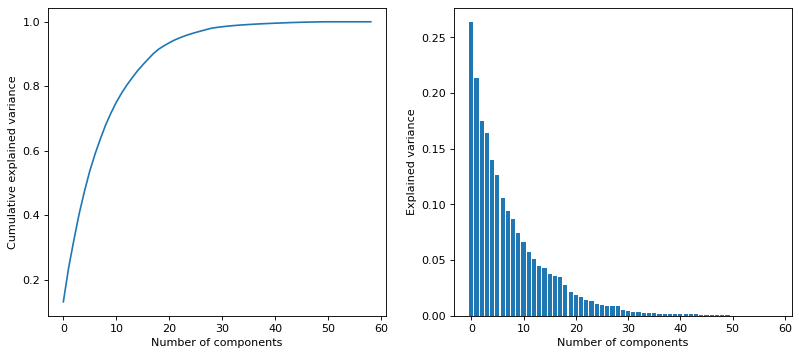

In [82]:
pca = PCA().fit(df_scale)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax0, ax1 = axes.flatten()

ax0.plot(np.cumsum(pca.explained_variance_ratio_))
ax0.set_xlabel('Number of components')
ax0.set_ylabel('Cumulative explained variance')

ax1.bar(range(59),pca.explained_variance_)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained variance')

plt.show()

This code calculates the number of principal components needed to explain at least $x$% of the variance in the data.

- In simpler terms, `n_PCA_50` is the number of principal components needed to reach just below 50% of the explained variance.

1. `pca.explained_variance_ratio_` provides the proportion of the dataset's total variance that each principal component explains.
 
2. `np.cumsum(pca.explained_variance_ratio_)` computes the cumulative sum of explained variances. This array tells us how much total variance is explained as we include more and more principal components.

3. `np.cumsum(pca.explained_variance_ratio_)>0.5` results in a Boolean array, where `True` represents that the cumulative variance is more than 50%, and `False` means it's less.

4. `np.size(...)` calculates the total number of components.

5. `np.count_nonzero(...)` counts how many components have a cumulative explained variance of more than 50%.

6. Subtracting the count of `True` values from the total gives the index (or position) of the last component which is below the 50% cumulative variance threshold.



In [83]:
n_PCA_50 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.5) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.5)


n_PCA_80 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.8) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.8)


n_PCA_90 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.9) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.9)


print(format(n_PCA_50) + " components explain 50% of variance.")
print(format(n_PCA_80) + " components explain 80% of variance.")
print(format(n_PCA_90) + " components explain 90% of variance.")

5 components explain 50% of variance.
12 components explain 80% of variance.
17 components explain 90% of variance.


#### Lets use 17 components, since 90% of variance explained 

In [84]:
n = 17

# rename some columns for interpretable plot
col_names = [i.replace('shipping_option_name_', '(Shipped by) ').replace('origin_country_', '(Country) ').replace('product_color_', '(Color) ')  for i in df_scale.columns]

# Define component names
comp_names = [f'{i} Comp' for i in range(1,n+1)]

We plot our 59 variables in columns and principial components in rows. Due to this, We can see how much particular variable contributes to a particular component and what is its sign (-/+)

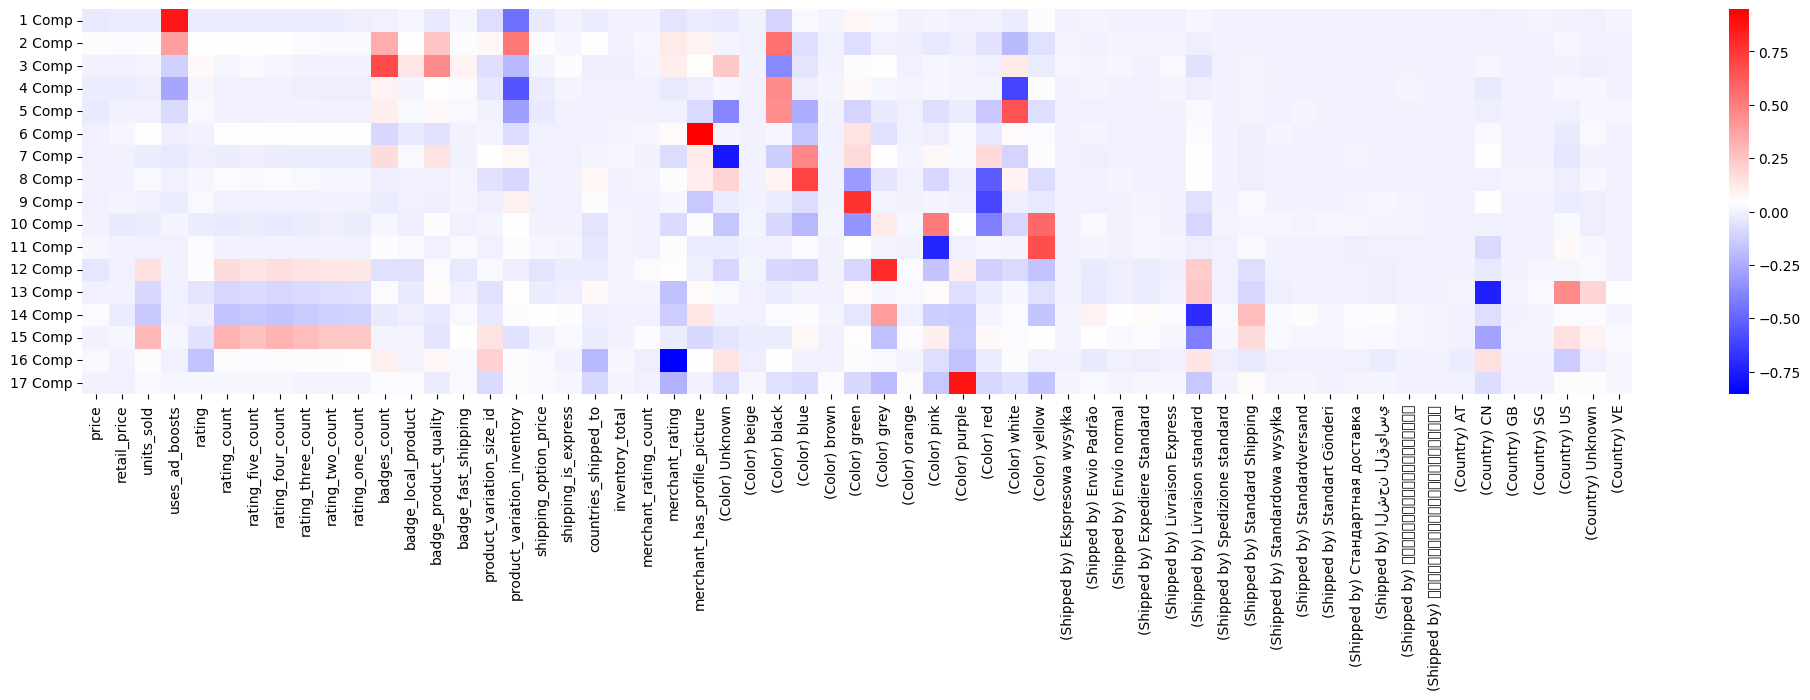

In [85]:
import seaborn as sns


pca = PCA(n).fit(df_scale)
X_pca = pca.transform(df_scale) 



plt.figure(figsize=(25, 5))
sns.heatmap(pca.components_,
            cmap='bwr',
            yticklabels=comp_names,
            xticklabels=col_names,
            cbar_kws={"orientation": "vertical"})

plt.show()


### We can now ask 2 questions:

#### 1) Which features contribute most to any given component 
- what information are the `archetypes` capturing?


In [86]:
import pandas as pd

def significant_features_contribution(pca_components, threshold, columns):
    """
    Returns features with their contributions that are above a specified threshold for each principal component in a multi-index DataFrame.

    Parameters:
    - pca_components: The components_ attribute from a PCA model.
    - threshold: The threshold for determining significant contributions.
    - columns: The names of the original features.

    Returns:
    - A multi-index DataFrame with principal components as level 0 index, features as level 1 index, and contributions as values.
    """

    multi_index_data = []
    
    # Iterate through each principal component
    for component_idx, component in enumerate(pca_components):
        
        # Iterate through each feature's contribution to the component
        for feature_idx, feature_contribution in enumerate(component):
            if abs(feature_contribution) > threshold:
                multi_index_data.append((component_idx, columns[feature_idx], feature_contribution))

    # Convert the data into a DataFrame
    df = pd.DataFrame(multi_index_data, columns=['Component', 'Feature', 'Contribution'])
    df = df.set_index(['Component', 'Feature'])
    
    return df





In [87]:
threshold = 0.2
df_multi_indexed = significant_features_contribution(pca.components_, threshold, df_scale.columns)
df_multi_indexed

Contribution
Component Feature                                              
0         uses_ad_boosts                               0.866594
          product_variation_inventory                 -0.459474
1         uses_ad_boosts                               0.386829
          badges_count                                 0.339908
          badge_product_quality                        0.251094
          product_variation_inventory                  0.523419
          product_color_black                          0.540696
          product_color_white                         -0.200013
2         badges_count                                 0.679886
          badge_product_quality                        0.458610
          product_variation_inventory                 -0.203819
          product_color_Unknown                        0.235711
          product_color_black                         -0.373485
3         uses_ad_boosts                              -0.271519
          product_variation_inventory                 -0.560470
          product_color_black                          0.460175
          product_color_white                         -0.611570
4         product_variation_inventory                 -0.299578
          product_color_Unknown                       -0.383160
          product_color_black                          0.444778
          product_color_blue                          -0.237910
          product_color_white                          0.654662
5         merchant_has_profile_picture                 0.946969
6         product_color_Unknown                       -0.767854
          product_color_blue                           0.473469
7         product_color_Unknown                        0.200001
          product_color_blue                           0.713183
          product_color_green                         -0.308514
          product_color_red                           -0.531157
8         product_color_green                          0.763917
          product_color_red                           -0.605377
9         product_color_blue                          -0.205931
          product_color_green                         -0.331409
          product_color_pink                           0.511425
          product_color_red                           -0.400357
          product_color_yellow                         0.579403
10        product_color_pink                          -0.723837
          product_color_yellow                         0.670867
11        product_color_grey                           0.798308
          shipping_option_name_Livraison standard      0.222731
12        shipping_option_name_Livraison standard      0.243096
          origin_country_CN                           -0.741425
          origin_country_US                            0.459377
13        product_color_grey                           0.391191
          shipping_option_name_Livraison standard     -0.695328
          shipping_option_name_Standard Shipping       0.276031
14        units_sold                                   0.293174
          rating_count                                 0.318674
          rating_five_count                            0.266681
          rating_four_count                            0.315100
          rating_three_count                           0.284210
          rating_two_count                             0.248676
          rating_one_count                             0.245579
          shipping_option_name_Livraison standard     -0.412533
          origin_country_CN                           -0.275388
15        product_variation_size_id                    0.207165
          countries_shipped_to                        -0.205277
          merchant_rating                             -0.856891
16        merchant_rating                             -0.224469
          product_color_purple                         0.873543

It seems that the 1st component is vastly dominated by 'uses_ad_boosts'. 

#### 2) What is the maximum contribution a feature makes to any component
- which are the most important features overall for reconstructing the data

In [88]:


def extract_significant_contributions(components, columns, threshold=0.2):
    """
    Extracts features with contributions that exceed a given threshold from PCA components.

    Parameters:
    - components: The components_ attribute from a PCA model.
    - columns: The names of the original features.
    - threshold: The threshold for considering significant contributions (default is 0.2).

    Returns:
    - A DataFrame with feature names and their maximum absolute contributions.
    """
    
    def ExtractColumn(lst, j):
        return [item[j] for item in lst]
    
    # Initialize a list of zeros with a length equal to the number of columns
    PCA_vars = [0] * len(columns)

    # Iterate through each index and corresponding feature name in the columns
    for i, feature in zip(range(len(columns)), columns):
        # Extract the i-th column from the PCA components
        x = ExtractColumn(components, i)

        # Check if the absolute maximum or minimum of x exceeds the threshold
        if ((max(x) > threshold) | (min(x) < -threshold)):
            # If absolute max is greater than absolute min, set the max value to PCA_vars[i]
            if abs(max(x)) > abs(min(x)):
                PCA_vars[i] = max(x)
            else:  # Otherwise, set the min value to PCA_vars[i]
                PCA_vars[i] = min(x)
        else:
            # If neither max nor min exceed threshold, set the value to 0
            PCA_vars[i] = 0

    # Convert PCA_vars and column names into a DataFrame
    PCA_vars_df = pd.DataFrame(list(zip(columns, PCA_vars)), columns=('Name', 'Max absolute contribution'))

    # Filter out rows where the 'Max absolute contribution' is 0
    PCA_vars_df = PCA_vars_df[(PCA_vars_df['Max absolute contribution'] != 0)]

    # Reset the index of the DataFrame
    return PCA_vars_df.reset_index(drop=True)




In [118]:
thresh = 0.2
resulting_df = extract_significant_contributions(pca.components_, df_scale.columns, thresh)
resulting_df.sort_values('Max absolute contribution')

,Name,Max absolute contribution
13,merchant_rating,-0.856891
15,product_color_Unknown,-0.767854
27,origin_country_CN,-0.741425
20,product_color_pink,-0.723837
25,shipping_option_name_Livraison standard,-0.695328
22,product_color_red,-0.605377
11,product_variation_inventory,-0.560470
12,countries_shipped_to,-0.205277
10,product_variation_size_id,0.207165
7,rating_one_count,0.245579





### Above is an example of problems PCA can run into. 

- Here, even our lower dimensional representation has alot of dimensions . 
- Thats alot of different archetypes your combining to express each row. 
- What does $2$% of `component 1` and $5$% of `component 2` even mean? Complicated to think about


<center><img src="mat_fac.png" alt="Drawing" style="width: 400;"/></center>

### **Solution**: Constrain your optimization to limit the number of archetypes used to explain any row! 



## Sparse PCA

Sparse PCA is a modification of standard PCA, to extract principal components with more non-zero weights, enhancing interpretability. 

We are telling the algorithm that each representation must be ***explained*** by at most `k` different archetypes, where `k` is smaller than the total number of archetypes, or components, you have fitted to.


- It's influenced by the L1 penalty, reminiscent of techniques like LASSO.
- Sparse PCA focuses on specific features of the data, minimizing noise interference.

 Here are its key benefits:

1. **Interpretability**: Sparse PCA offers more easily understood principal components by highlighting significant variables.
2. **Dimensionality Reduction**: Like PCA, it's used to reduce data dimensions, especially when only a few original variables are significant.
3. **Feature Selection**: Highlights important features for tasks like regression or classification.
4. **Noise Reduction**: Filters out irrelevant or noisy features, improving the signal-to-noise ratio.
5. **Specific Applications**: Useful in genomics, finance, and neuroimaging where only a subset of features or regions are relevant.



In [90]:
from sklearn.decomposition import SparsePCA

- The parameter `alpha` controls sparsity, higher values result in sparser components (default is `1`)

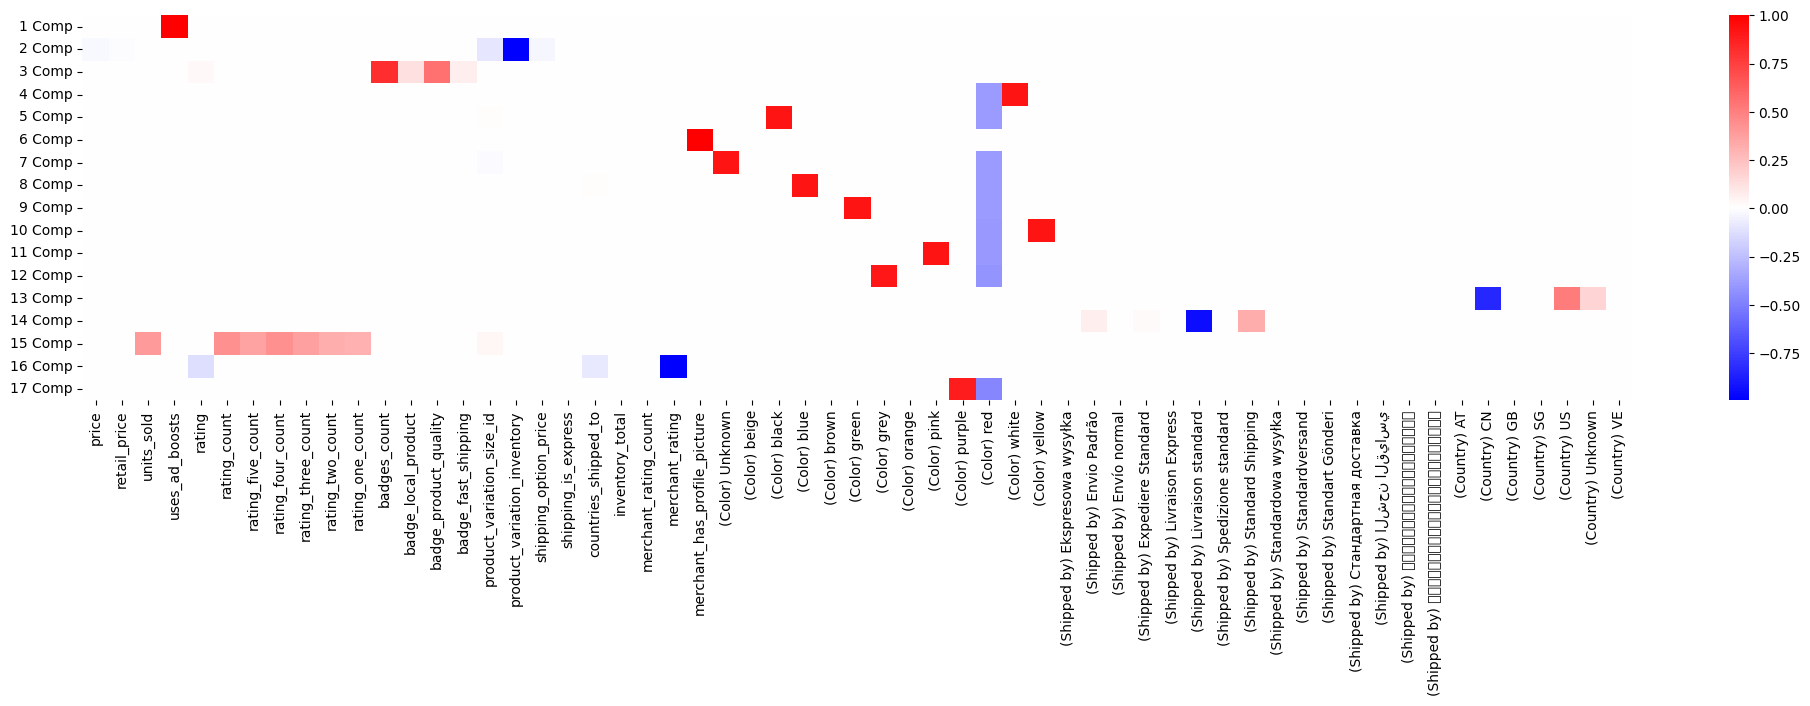

In [91]:
SPCA = SparsePCA(n_components=n, alpha=.5)
SPCA_fit = SPCA.fit(df_scale)
SPCA_transformed = SPCA.transform(df_scale)


# Define component names
comp_names = [f'{i} Comp' for i in range(1,n+1)]

plt.figure(figsize=(25, 5))
sns.heatmap(SPCA_fit.components_,
            cmap='bwr',
            yticklabels=comp_names,
            xticklabels=col_names,
            cbar_kws={"orientation": "vertical"})

plt.show()

- Results show that output matrix meets sparsity requirements. 

- Just by looking at the components, if im a manufacturer, maybe I dont want to hold stock that is Purple, orange, brown or beige..but this is just a preliminary assessment

- We can again fish out top contributing features as we did

In [92]:
thresh = 0.2
resulting_df = extract_significant_contributions(SPCA_fit.components_, df_scale.columns, thresh)
resulting_df

,Name,Max absolute contribution
0,units_sold,0.393854
1,uses_ad_boosts,1.000000
2,rating_count,0.436668
3,rating_five_count,0.361228
4,rating_four_count,0.432257
5,rating_three_count,0.374874
6,rating_two_count,0.315134
7,rating_one_count,0.309067
8,badges_count,0.815308
9,badge_product_quality,0.561070


# Part 3 : Non-Negative Matrix factorization

[Non-negative Matrix Factorization](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF) (NMF) is a matrix factorization technique where the constraint is that the matrices produced are non-negative. 




Given a non-negative matrix $V$, NMF aims to find two non-negative matrices $W$ and $H$ such that:

$ V \approx W \times H $

Here:
- $V$ is the original matrix of size $ m \times n $,
- $W$ is of size $m \times k$,
- $H$ is of size $k \times n$,
- $k$ is typically chosen such that $k < min(m, n)$, meaning we're seeking a lower-rank approximation of $V$.

#### All the elements of these matrices are greater than or equal to zero. 
- Provides a parts-based representation because the non-negativity constraint tends to make the resulting matrices sparse, meaning that many of the elements are zero or close to zero.



**Comparison with PCA**:
While both PCA and NMF are dimensionality reduction techniques, there are key differences:
- PCA can produce negative values in its components, while NMF components are strictly non-negative. 

- NMF often results in a more interpretable parts-based representation due to its non-negativity constraint.  (dog + cat is more interpretable than dog -cat)

- PCA, on the other hand, results in orthogonal components that don't necessarily have the same level of interpretability.
  


In [93]:
root = 'C:/Users/npurk/Downloads/archive (2)/'

#### This is a dataset describing customer shopping trends taken from [Kaggle](https://www.kaggle.com/datasets/iamsouravbanerjee/customer-shopping-trends-dataset)

In [94]:
df = pd.read_csv(f'{root}/shopping_trends.csv').drop('Customer ID', axis=1)

In [95]:
df.shape

(3900, 18)

In [96]:
df.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


- Lets scale numeric features and one-hot encode binary features

In [97]:
object_cols = df.select_dtypes('O').columns

num_data = df.drop(object_cols, axis=1)

scaler = MinMaxScaler()

num_scaled = pd.DataFrame(scaler.fit_transform(num_data), columns = num_data.columns)

scaled_data = num_scaled.assign(**pd.get_dummies(df[object_cols]))

In [98]:
scaled_data.shape

(3900, 149)

In [99]:
from sklearn.decomposition import NMF

In [100]:
n = 30
NNMF = NMF(n_components=n)
NMF_fit = NNMF.fit(scaled_data)

        



<details>

<summary> <b> Notes on interpretability for NMF results </b></summary>

When you run `NMF` on a tabular dataset with non-negative values, you'll obtain two matrices:
- The basis matrix (sometimes called "W") and the coefficient matrix (sometimes called "H").
- The product of these matrices approximates the original data matrix.

Here's how you can interpret the results:

1. **Basis Matrix (W)**:
    - Each row of your original dataset is represented as a linear combination of the rows in the basis matrix.
    - The rows of the basis matrix can be seen as "components" or "patterns" in the data. 
    - Each component represents some latent feature of your data.
    - For instance, if you're working with a document-term matrix, the basis matrix might represent "topics", with each row giving the weight of different words in that topic.

2. **Coefficient Matrix (H)**:
    - It describes how much each component (row of the basis matrix) contributes to each original column.
    - In the context of a document-term matrix, it would show the weight or presence of each topic (from the basis matrix) in each document.

3. **Interpretation Steps**:

    a. **Identify Patterns**: 
        - Look at the rows of the basis matrix (W). Depending on the domain of your data, these might represent commonly occurring patterns. For instance:  
            - **For Text Data**: Rows will indicate "topics", and the values in each row will highlight the importance of different words for that topic.  
            - **For Purchase Data**: Rows might indicate common purchasing patterns, and each row's values would indicate the significance of different products in that pattern.

    b. **Determine Contribution**: 
        - Examine the coefficient matrix (H) to determine how much each pattern (from the basis matrix) contributes to the original columns.
        - For example, if the columns represent different items purchased, and the patterns represent purchasing habits, the coefficient matrix will tell you which purchasing habits are most prominent for each item.

    c. **Visualize**: 
        - Heatmaps can be an effective way to visualize the components and their importance. The basis matrix can be visualized to see the weightage of features in each component. The coefficient matrix can be visualized to see the prominence of each component across different samples.

    d. **Compare with Original Data**: 
        - After understanding the patterns from NMF, go back to your original data. Check if the identified patterns or topics align with what you know about the dataset.

</details>

In [101]:

# Assuming your data is stored in a DataFrame called df
item_columns = [col for col in scaled_data.columns if 'Item Purchased_' in col]


# Filter out only the item columns
purchase_data = scaled_data[item_columns]

When you apply Non-negative Matrix Factorization `NMF` to a dataset, you decompose the original matrix $V$ into two matrices $W$ and $H$. In the context of NMF applied to datasets where columns are features:




In [102]:
# Number of components or latent features you want to extract
n_components = 10

model = NMF(n_components=n_components, init='random', random_state=42)



- $W$ represents the basis vectors, and each row in $W$ can be thought of as an archetype, a "topic" or latent feature.

In [103]:
W = model.fit_transform(purchase_data)

- $H$ represents the coefficients, detailing how much each column (or feature) in the original matrix $V$ contributes to the topics or latent features.

In [104]:
H = model.components_

#### Code below will yield the top purchases for each component.

- Interpreting each component as a purchasing pattern, the items in each component can be seen as commonly co-purchased items, or products that are typically bought together.

- Adjust `n_components` and `n_top_items` based on the specific results and your desired granularity can help to fine-tune the patterns you're identifying. 

In [105]:
n_top_items = 3

for i, topic in enumerate(H):
    print(f"Top items for component {i + 1}:")
    print([item_columns[i] for i in topic.argsort()[-n_top_items:][::-1]])
    print("\n")

Top items for component 1:
['Item Purchased_Shirt', 'Item Purchased_Sandals', 'Item Purchased_Skirt']


Top items for component 2:
['Item Purchased_Jewelry', 'Item Purchased_Belt', 'Item Purchased_Sunglasses']


Top items for component 3:
['Item Purchased_Socks', 'Item Purchased_Scarf', 'Item Purchased_T-shirt']


Top items for component 4:
['Item Purchased_Coat', 'Item Purchased_Handbag', 'Item Purchased_Sneakers']


Top items for component 5:
['Item Purchased_Pants', 'Item Purchased_Jacket', 'Item Purchased_Sunglasses']


Top items for component 6:
['Item Purchased_Dress', 'Item Purchased_Belt', 'Item Purchased_Backpack']


Top items for component 7:
['Item Purchased_Hat', 'Item Purchased_Shoes', 'Item Purchased_Gloves']


Top items for component 8:
['Item Purchased_Blouse', 'Item Purchased_Shorts', 'Item Purchased_Sandals']


Top items for component 9:
['Item Purchased_Hoodie', 'Item Purchased_Sneakers', 'Item Purchased_T-shirt']


Top items for component 10:
['Item Purchased_Sweate

In [106]:
#significant_features_contribution(NNMF.components_, 0.2, scaled_data.columns)

In [107]:


H = NNMF.components_
H.shape

n_top_items = 5

for i, topic in enumerate(H):
    print(f"Top items for component {i + 1}:")
    print([scaled_data.columns[i] for i in topic.argsort()[-n_top_items:][::-1]])
    print("\n")

Top items for component 1:
['Discount Applied_No', 'Promo Code Used_No', 'Subscription Status_No', 'Gender_Female', 'Payment Method_Venmo']


Top items for component 2:
['Subscription Status_Yes', 'Promo Code Used_Yes', 'Discount Applied_Yes', 'Gender_Male', 'Payment Method_Venmo']


Top items for component 3:
['Category_Clothing', 'Shipping Type_Store Pickup', 'Item Purchased_Shirt', 'Item Purchased_Blouse', 'Item Purchased_Pants']


Top items for component 4:
['Size_M', 'Age', 'Color_Violet', 'Location_Florida', 'Color_Lavender']


Top items for component 5:
['Season_Spring', 'Review Rating', 'Previous Purchases', 'Gender_Male', 'Payment Method_Credit Card']


Top items for component 6:
['Season_Winter', 'Previous Purchases', 'Review Rating', 'Gender_Male', 'Payment Method_Credit Card']


Top items for component 7:
['Size_L', 'Age', 'Color_Blue', 'Color_Yellow', 'Location_Louisiana']


Top items for component 8:
['Season_Summer', 'Previous Purchases', 'Review Rating', 'Gender_Male', 

### What to look for?

Features frequently combine in distinct ways, reflecting common patterns. Based on our columns, these patterns, or "topics," might include:

**Demographic Topics:** Highlighting purchasing habits based on characteristics such as age, gender, and location. An example might be buying trends specific to middle-aged females in California.

**Product Preference Topics:** These topics showcase items often purchased together. For instance, a prevalent combination could be jeans, t-shirts, and sneakers, suggesting a casual attire trend.

**Shopping Behavior Topics:** These encompass patterns linked to how customers shop. This could involve topics indicating frequent shoppers who often use promo codes and favor PayPal.

**Fashion Style Topics:** These topics dive into trends in size, color, and season. An example could be a preference for large, blue items during the summer.

**Shipping and Payment Topics:** These focus on delivery preferences and payment modes. For instance, a topic might cater to those choosing 2-day shipping and paying via credit card.

**Promotion-Driven Topics:** Specifically targeting customers responsive to promotions, as indicated by attributes like using promo codes or applying discounts.

- Finally, we can use the `NMF` output for some clustering

In [108]:
tt = NNMF.fit_transform(scaled_data)

In [109]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


Elbow Method to determine the number of clusters to be formed:


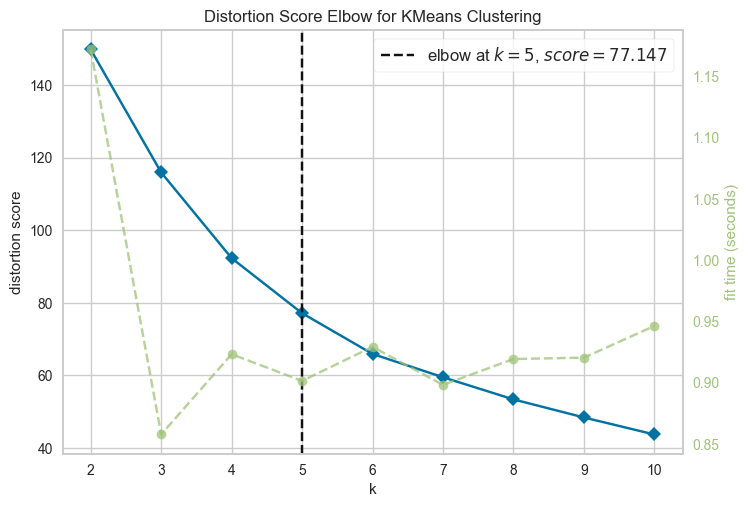

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(tt)
Elbow_M.show()

-  5 clusters have the best distortion score

In [111]:
clusterer = KMeans(n_clusters=5)

clusterer.fit(tt)

KMeans(n_clusters=5)

In [112]:
from sklearn.metrics import silhouette_score
nfm_cluster_labels = clusterer.labels_
silhouette_score(tt, nfm_cluster_labels)

0.3573621354806353

- Samples per cluster

In [113]:
from collections import Counter

Counter(clusterer.labels_)

Counter({3: 773, 4: 563, 0: 547, 2: 437, 1: 1580})

- And how would `KMeans` perform on the original data?

In [114]:
clusterer = KMeans(n_clusters=5)

clusterer.fit(scaled_data)
silhouette_score(scaled_data, clusterer.labels_)

0.049073302767375336

In [115]:
def ExtractColumn(lst, j):
    return [item[j] for item in lst]

- Just like before, the code filters out and captures significant contributions of features in the NMF components for the provided dataset 

In [116]:
# Initialize a list named `NMF_vars` filled with zeros. The length is equal to the number of columns in the dataframe `scaled_data`.
NMF_vars = [0]*len(scaled_data.columns)

# Loop through each index (`i`) and corresponding column name (`feature`) in the `scaled_data` dataframe.
for i, feature in zip(range(len(scaled_data.columns)),scaled_data.columns):

    # Extract the `i`-th column from the components of the NMF fit.
    x = ExtractColumn( NMF_fit.components_,i)
    
    # Check if the absolute maximum or minimum of the extracted column `x` exceeds 0.1 in magnitude.
    if ((max(x) > 0.1) | (min(x) < -0.1)):
        
        # Compare the absolute values of the max and min of `x`. Assign the greater absolute value to `NMF_vars[i]`.
        if abs(max(x)) > abs(min(x)):
            NMF_vars[i] = max(x)
        else:
            NMF_vars[i] = min(x)                 
    else:
        # If neither max nor min of `x` exceeds the threshold, set the corresponding value in `NMF_vars` to 0.
        NMF_vars[i] = 0

# Create a dataframe with column names from `scaled_data` and their corresponding maximum absolute contributions.
NMF_vars = pd.DataFrame(list(zip(scaled_data.columns,NMF_vars)),columns=('Name','Max absolute contribution'),index=range(1,150,1))      

# Filter the dataframe to keep only the rows where the 'Max absolute contribution' is not 0.
NMF_vars = NMF_vars[(NMF_vars['Max absolute contribution']!=0)]



In [117]:
scaled_data[NMF_vars.Name ].assign(labels =  nfm_cluster_labels).groupby('labels').mean()#, std, whatever you want

,Age,Purchase Amount (USD),Review Rating,Previous Purchases,Gender_Female,Gender_Male,Item Purchased_Backpack,Item Purchased_Belt,Item Purchased_Blouse,Item Purchased_Boots,...,Preferred Payment Method_Debit Card,Preferred Payment Method_PayPal,Preferred Payment Method_Venmo,Frequency of Purchases_Annually,Frequency of Purchases_Bi-Weekly,Frequency of Purchases_Every 3 Months,Frequency of Purchases_Fortnightly,Frequency of Purchases_Monthly,Frequency of Purchases_Quarterly,Frequency of Purchases_Weekly
labels,,,,,,,,,,,,,,,,,,,,,
0,0.484636,0.508684,0.482779,0.485468,0.343693,0.656307,0.038391,0.043876,0.056673,0.042048,...,0.177331,0.160878,0.177331,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000
1,0.504637,0.500396,0.507924,0.484113,0.563924,0.436076,0.036076,0.040506,0.048101,0.026582,...,0.153165,0.179747,0.156962,0.211392,0.0,0.206329,0.189241,0.200000,0.0,0.193038
2,0.501628,0.481407,0.503341,0.495820,0.000000,1.000000,0.029748,0.045767,0.041190,0.045767,...,0.171625,0.146453,0.176201,0.178490,0.0,0.237986,0.205950,0.201373,0.0,0.176201
3,0.497512,0.488842,0.500543,0.509702,0.000000,1.000000,0.040103,0.040103,0.027167,0.036223,...,0.165589,0.178525,0.169470,0.206986,0.0,0.199224,0.197930,0.192755,0.0,0.203105
4,0.513185,0.499800,0.491012,0.527640,0.300178,0.699822,0.037300,0.039076,0.044405,0.055062,...,0.166963,0.182948,0.143872,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000


<details>

<summary> Here are some things I found in the clusters </summary>

Using both the mean and standard deviation values per clusters, I found:

#### Cluster 0: "Male Accessories Enthusiast"
- **Age & Purchase Behavior**: Average Age, Average Purchase Amount, Average Review Rating, and Average Previous Purchases. 
- **Gender & Product Preferences**: Predominantly Male (~65.6%); More interested in Clothing (~45.1%) than Accessories (~32.9%).
- **Size Preference**: Medium (~45.3%) is preferred over Large (~26.3%) and Small (~17.2%).
- **Seasonal Preference**: No significant preference. Roughly evenly spread across seasons.
- **Payment & Shipping**: Tend to use Credit Card slightly more (18.4%) but also Cash (17.3%).
- **Preferred Payment Method**: Cash (~17.9%) but also PayPal (~16%).
- **Purchase Frequency**: Data suggests they don't make frequent purchases based on the provided categories.

#### Cluster 1: "Regular Balanced Shopper"
- **Age & Purchase Behavior**: Slightly above-average Age and Purchase Amount; Slightly above-average Review Rating.
- **Gender & Product Preferences**: Gender is more balanced (Male ~43.6%); Closer preference between Clothing (45.6%) and Accessories (31%).
- **Size Preference**: Prefer Medium (44.4%) and Large (27.6%) sizes.
- **Seasonal Preference**: Fall (26.4%) is slightly more preferred.
- **Payment & Shipping**: Balanced payment methods.
- **Preferred Payment Method**: PayPal (~20.6%) is slightly more preferred.
- **Purchase Frequency**: Every 3 months (~20.6%) and Fortnightly (~18.9%).

#### Cluster 2: "Loyal Male Regulars"
- **Age & Purchase Behavior**: Average age; Average Purchase Amount. 
- **Gender & Product Preferences**: Exclusively Male (100%); Slight preference for Clothing (44.1%).
- **Size Preference**: Preference for Medium (44.9%) and Large (28.3%) sizes.
- **Seasonal Preference**: More balanced across the seasons.
- **Payment & Shipping**: Balanced payment methods.
- **Preferred Payment Method**: Slightly prefer PayPal (~17.8%).
- **Purchase Frequency**: Every 3 months (~19.9%) and Fortnightly (~19.7%).

#### Cluster 3: "Diverse Male Shoppers"
- **Age & Purchase Behavior**: Average Age and Purchase Amount. 
- **Gender & Product Preferences**: Exclusively Male (100%); Preference for Clothing (44.8%).
- **Size Preference**: Preference for Medium (43.6%) size.
- **Seasonal Preference**: Spring (26.4%) and Summer (26.2%) are slightly preferred.
- **Payment & Shipping**: Slight preference for Credit Card (15.9%).
- **Preferred Payment Method**: Prefer Cash (~18.2%).
- **Purchase Frequency**: Every 3 months (~19.7%).

#### Cluster 4: "Year-Round Oldies"
- **Age & Purchase Behavior**: Above-average Age; Average Purchase Amount. 
- **Gender & Product Preferences**: Predominantly Male (~64.3%); Strong preference for Clothing (40.8%).
- **Size Preference**: Strong preference for Medium (48.2%) size.
- **Seasonal Preference**: Balanced among all seasons.
- **Payment & Shipping**: Slight preference for Credit Card (18.6%).
- **Preferred Payment Method**: Slightly prefer PayPal (~18%).
- **Purchase Frequency**: No significant frequency as per provided categories.

#### Insights from Standard Deviation:
- The Gender_Male feature's standard deviation is significantly high for Clusters 0 and 4 (around 0.47-0.48), suggesting some variation within those clusters in terms of gender distribution.
- Payment method preferences show consistent standard deviations across clusters. However, Cluster 1 has a slightly higher standard deviation for the "Frequency of Purchases" features, indicating more varied purchase frequencies within this cluster.

In summary, the clusters seem to segment primarily based on gender and product type preference, with nuances in payment methods, size, and seasonal preferences. Using the means and standard deviations, it becomes clear that clusters have some unique characteristics which can be leveraged for targeted marketing and promotions.
<details>

## Summary

Non-negative Matrix Factorization (NMF), Sparse Principal Component Analysis (Sparse PCA), and Kernel Principal Component Analysis (Kernel PCA) are all techniques used for dimensionality reduction and data decomposition. However, they are based on different mathematical principles and have different use cases. Here's a comparison:

### 1. **Non-negative Matrix Factorization (NMF)**:
- **Methodology**: NMF decomposes a non-negative matrix \( V \) into two non-negative matrices \( W \) and \( H \) such that \( V \approx W \times H \).
- **Assumptions**: Data must be non-negative. This makes NMF particularly suitable for datasets where negative values don't make sense (e.g., image data, word counts).
- **Properties**:
    - **Non-negativity**: Respects the natural non-negative nature of sales figures.
    - **Interpretability**: Reveals clear purchasing patterns, aiding in actionable insights.
    - **Additive Combinations**: Represents sales patterns as combinations of typical behaviors.
    - **Dimensionality Reduction**: Extracts crucial sales trends from high-dimensional data.
    - **Anomaly Detection**: Helps spot unusual purchase patterns.

### 2. **Sparse PCA**:
- **Methodology**: An extension of traditional PCA that promotes sparsity in the principal components.
- **Assumptions**: Assumes that data variance can be captured using fewer original variables (while keeping the number of components the same).
- **Use Cases**:
  - High dimensional data where interpretability of components is essential.
  - When it's important to identify which original features contribute most to the variance.
- **Properties**:
  - Produces sparse principal components, making them more interpretable.
  - Suitable for datasets where many original variables might be redundant or irrelevant.

### 3. **Kernel PCA**:
- **Methodology**: Uses the kernel trick to map data to a higher-dimensional feature space and then applies PCA in this space. It's essentially PCA in a transformed space.
- **Assumptions**: Assumes that the data, when mapped into a higher-dimensional space, becomes linearly separable.
- **Use Cases**:
  - Non-linear datasets where traditional PCA would not capture the variance effectively.
  - For data that has a clear non-linear structure.
- **Properties**:
  - Can uncover complex, non-linear patterns in the data.
  - Choosing the right kernel and its parameters is crucial and might require domain knowledge or experimentation.
  - Might be computationally more intensive than standard PCA, especially with large datasets.

**In summary**:
- Use **NMF** when the data is non-negative and you're looking for additive, parts-based representations.
- Use **Sparse PCA** when you want interpretable principal components with a focus on fewer original variables.
- Use **Kernel PCA** when dealing with data that has non-linear patterns that can't be captured by linear methods.

